In [3]:
!pip install opencv-python numpy tensorflow scikit-learn matplotlib wandb tdqm wurlitzer

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 32.7 MB/s eta 0:00:0000:01
  Created wheel for tdqm: filename=tdqm-0.0.1-py3-none-any.whl size=1322 sha256=a9a1f8e5e8f6d6a10261ac39b6547c269489f5a542e073f43a2d6f014dd72957
  Stored in directory: /root/.cache/pip/wheels/37/31/b8/7b711038035720ba0df14376af06e5e76b9bd61759c861ad92
Successfully built tdqm
  Attempting uninstall: keras
    Found existing installation: keras 3.1.1
    Uninstalling keras-3.1.1:
      Successfully uninstalled keras-3.1.1


In [4]:
#all the required dependencies of the project
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import random
import wandb

from typing import Tuple
from collections import Counter
import albumentations as A
from tqdm import tqdm
from typing import List
import json
import tensorflow.keras as keras 
import tensorflow as tf

2024-04-09 18:59:35.881122: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 18:59:35.881275: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 18:59:36.056283: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
class CONFIG:
    ROOT_DIRECTORY = "/kaggle/input/wlasl-processed"
    JSON_FILE = "WLASL_v0.3.json"
    NSLT_FILE = "nslt_100.json"
    VIDEO_FOLDER = "videos"

    #mean=[0.485, 0.456, 0.406]
    #std=[0.229, 0.224, 0.225]
    mean = [0, 0, 0]
    std = [1,1,1]
    DEBUG = True
    
    P_OF_TRANSFORM = 0.9
    P_OF_TRANSFORM_COLOR = 0.2
    
    SHIFT_LIMIT=0.1
    SCALE_LIMIT=0.1
    ROTATE_LIMIT=10
    
    # set to small, when prototyping, or 0 when deploying to cloud or PC with loads of RAM
    DATA_LIMIT = 100
    FRAME_SIZE = 30
    
    
    BATCH_SIZE = 8
    PORTION_OF_DATA_FOR_TRAINING = 0.8

    ROUND_DIGIT = 3
    #WANDB_RUN = "mediapipe-asl-dataset"

In [6]:
#USE THIS - decay rate of 0.09
def update_mhi(prev_frame, current_frame, mhi, decay=0.09):
    # Compute the absolute difference between the current and the previous frame
    frame_diff = cv2.absdiff(current_frame, prev_frame)
    
    # Convert the frame difference to grayscale and threshold it
    gray_diff = cv2.cvtColor(frame_diff, cv2.COLOR_BGR2GRAY)
    _, motion_mask = cv2.threshold(gray_diff, 25, 1, cv2.THRESH_BINARY)
    
    # Convert the single-channel motion mask to a 3-channel mask
    motion_mask_3ch = cv2.merge([motion_mask, motion_mask, motion_mask])
    
    # Update the MHI: New motion is added with a value of 1, and existing motion history decays
    # Ensure that both mhi and motion_mask_3ch are floats for correct operation
    mhi = (mhi * (1 - decay)) + np.float32(motion_mask_3ch)
    
    # Ensure MHI values are capped at 1
    mhi = np.clip(mhi, 0, 1)
    
    return mhi

#### Apply Data Augmentation to Dataset

In [7]:
from math import ceil, sqrt

def visualize_video(frames, save_path=None, mult=2, show=True):

    # load the frame 
    # frames = get_video(found_ids[0])

    # calculate the grid
    image_cnt = frames.shape[0]
    rounded_cnt = ceil(sqrt(image_cnt))

    # calculate the width/height ratio
    ratio = frames.shape[1] / frames.shape[2]

    # create grid of arrays
    fig, axs = plt.subplots(rounded_cnt, rounded_cnt, figsize=( rounded_cnt*mult, ratio * rounded_cnt*mult))
    axs_flat = axs.flatten()

    # Loop through images and display each
    for i in range(rounded_cnt * rounded_cnt):
        if i < len(frames):
            axs_flat[i].imshow(frames[i])
        axs_flat[i].axis('off')  # Turn off axis
        axs_flat[i].set_title(i)

    plt.tight_layout()
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')        
    
    if show:
        plt.show()
    else:
        plt.close()

In [68]:
from sklearn.model_selection import train_test_split
from math import ceil

class SignRecognitionDataset(keras.utils.Sequence):

    def __init__(self, max_start : int, max_end) -> None:
        # setup the paths
        video_path = os.path.join(CONFIG.ROOT_DIRECTORY, CONFIG.VIDEO_FOLDER)
        dataset_description = os.path.join(CONFIG.ROOT_DIRECTORY)

        # load the filepaths for videos
        self.video_paths = [os.path.join(video_path, file) for file in os.listdir(video_path)]

        # load the dataset config json
        self.config_json = None
        with open(os.path.join(CONFIG.ROOT_DIRECTORY, CONFIG.JSON_FILE)) as f:
            self.config_json = json.load(f)

        # load the dataset json
        self.dataset_json = None
        with open(os.path.join(CONFIG.ROOT_DIRECTORY, CONFIG.NSLT_FILE)) as f:
            self.dataset_json = json.load(f)
        
        self.videos_paths = []
        self.paths_not_found = []
        self.labels = []
        self.start_frames = []
        self.end_frames = []
       
        self.dataset_json = None
        with open(os.path.join(CONFIG.ROOT_DIRECTORY, CONFIG.NSLT_FILE)) as f:
            self.dataset_json = json.load(f) 

        for el in tqdm(self.dataset_json.items()):
            video_id, properties = el[0], el[1]
            path = os.path.join(video_path, video_id + ".mp4")
            
            if not os.path.exists(path):
                self.paths_not_found.append(path)
                continue

            subset = properties["subset"]
            label, start, end = properties["action"]
            
            if start > max_start:
                continue
                
            if end > max_end:
                continue
            
            self.videos_paths.append(path)
            self.labels.append(label)
            self.start_frames.append(start)
            self.end_frames.append(end)
    
        self.videos_paths = np.array(self.video_paths)
        self.paths_not_found = np.array(self.paths_not_found)
        self.labels = np.array(self.labels)
        self.start_frames = np.array(self.start_frames)
        self.end_frames = np.array(self.end_frames)

        self.unique_labels = np.unique(self.labels)
        
    
    def preprocess_trajectory(self, traj : List[np.ndarray]):
        return traj
    
    def __len__(self):
        return len(self.videos_paths)

    def __getitem__(self, idx):
        path, label = self.videos_paths[idx], self.labels[idx]
        trajectory = SignRecognitionDataset.get_video(path)
        
        return self.preprocess_trajectory(trajectory), label

    def permutate(self):
        l = len(self.videos_paths)
        mask = np.arange(l)
        np.random.shuffle(mask)
        
        self.videos_paths = np.array(self.videos_paths)[mask]
        self.labels = np.array(self.labels)[mask]
        self.start_frames = np.array(self.start_frames)[mask]
        self.end_frames = np.array(self.end_frames)[mask]
        
    def sort_by_size(self):
        c = Counter(self.labels)
        _mask = sorted([ (10000 * c[l] + l, i) for i, l in enumerate(self.labels)])[::-1]
        mask_by_size = np.array([el[1] for el in _mask])

        self.video_paths        = np.array(self.video_paths)[mask_by_size]
        self.labels             = np.array(self.labels)[mask_by_size]
        self.start_frames       = np.array(self.start_frames)[mask_by_size]
        self.end_frames         = np.array(self.end_frames)[mask_by_size]

    def crop_video(self, trajectory : np.array) -> np.array:
        cropped = trajectory
        
        if self.FRAME_SIZE != 0:
            frame_size = len(trajectory)
            start = 0 
            
            if frame_size > self.FRAME_SIZE:
                start = np.random.randint(0, frame_size - self.FRAME_SIZE)
            cropped = trajectory[start: (start + self.FRAME_SIZE)]
                    
            if len(cropped) < self.FRAME_SIZE:
                necessary = self.FRAME_SIZE - len(cropped)
                t, h, w, c = trajectory.shape
                cropped = np.concatenate([cropped, np.zeros((necessary, h, w, c))], axis= 0)
                
            return cropped
                        
        return trajectory
                
    @staticmethod
    def get_video(video_path : str) -> List[np.ndarray]:

        if not os.path.exists(video_path):
            return None

        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            return None

        frames = []
        while cap.isOpened():
            ret, frame = cap.read()
            if ret:
                frame_array = np.array(frame)
                frames.append(cv2.cvtColor(frame_array, cv2.COLOR_BGR2RGB))
            else:
                break

        cap.release()
        return np.array(frames)

    @staticmethod
    def rescale_video(frames : np.ndarray, desired_shape) -> np.ndarray:
        refined = []
        for img in frames: 
            y, x, c = img.shape
            cropped = img[:, (x // 2 - y//2) : (x // 2 + y//2), :]
            scaled = cv2.resize(cropped, desired_shape)
            refined.append(scaled)
    
        return np.array(refined)
        
class SignRecognitionDatasetMHI(SignRecognitionDataset):

    def __init__(self, max_start: int, max_end, 
                 per_image_transform=None,
                 after_MHI_transform=None,
                 scaled_resolution : Tuple[int]= (224, 224),
                 frame_size:int=CONFIG.FRAME_SIZE,
                 data_limit : int = CONFIG.DATA_LIMIT,
                 decay : float = 0.7,
                 threshold_method : str = "regular",
                 threshold_val : float = 25/255.,
                 by_size=True,
                 batch_size=CONFIG.BATCH_SIZE,
                 train_val_split:float=CONFIG.PORTION_OF_DATA_FOR_TRAINING,
                 split:str="train") -> None:
        super().__init__(max_start, max_end)
        self.scaled_resolution = scaled_resolution
        self.DATA_LIMIT = data_limit
        self.by_size = by_size
        self.per_image_transform = per_image_transform
        self.after_MHI_transform = after_MHI_transform
        self.FRAME_SIZE = frame_size
        self.decay = decay
        self.threshold_method = threshold_method
        self.threshold_val = threshold_val
        self.batch_size = batch_size
        
        self.keywords = ["image" ] + list(str(i) for i in range(frame_size-1))
        
        self.sort_by_size()
        
        if self.DATA_LIMIT > 0:
            self.video_paths        = self.video_paths[:self.DATA_LIMIT]
            self.labels             = self.labels[:self.DATA_LIMIT]
            self.start_frames       = self.start_frames[:self.DATA_LIMIT]
            self.end_frames         = self.end_frames[:self.DATA_LIMIT]
        
        
        self.label_2_id = { key : i for i, key in enumerate(np.unique(self.labels))}
        if data_limit < 0:
            train_ds_x, val_ds_x = train_test_split(self.videos_paths, train_size=train_val_split, random_state=42)
            train_ds_y, val_ds_y = train_test_split(self.labels, train_size=train_val_split, random_state=42)
            
        else:
            self.unique_labels = np.unique(self.labels[:data_limit])
            self.label_2_id = { key : i for i, key in enumerate(np.unique(self.labels))}
            
            train_ds_x, val_ds_x = train_test_split(self.videos_paths[:data_limit], train_size=train_val_split, random_state=42)
            train_ds_y, val_ds_y = train_test_split(self.labels[:data_limit], train_size=train_val_split, random_state=42)
                                    
        if split.lower() == "train":
            self.videos_paths = train_ds_x
            self.labels = train_ds_y
            
        elif split.lower() == "val":
            self.videos_paths = val_ds_x
            self.labels = val_ds_y
        
        else: 
            raise Exception("")
        
    def preprocess_trajectory(self, traj : List[np.ndarray]):
        return SignRecognitionDataset.rescale_video(traj, self.scaled_resolution)
        
    def __len__(self):
        return int(ceil(len(self.videos_paths) / self.batch_size))

    def get_MHI_from_trajectory (self, traj : np.ndarray) -> np.ndarray:
        # timeframe, Width, height, channels
        ts, w, h, c = traj.shape
        
        mhi = np.zeros((w, h))
                
        for i in range(1, ts):
            frame_diff = np.abs(traj[i] - traj[i-1])
            gray_diff = np.mean(frame_diff, axis=2)
            
            _, binary_diff = cv2.threshold(gray_diff, self.threshold_val, 1.0, cv2.THRESH_BINARY)
    
    
            mhi = mhi * (1.0 - self.decay) + binary_diff

        mhi = mhi.reshape(mhi.shape[0], mhi.shape[1], 1)
        return np.concatenate([mhi,mhi,mhi], axis=2)

        

    def get_single(self, idx):
        trajectory = SignRecognitionDataset.get_video(self.videos_paths[idx])  
        trajectory, label = self.crop_video(self.preprocess_trajectory(trajectory)), self.labels[idx]

        if self.per_image_transform is not None:            
            frames = {self.keywords[i] : frame for i, frame in enumerate(trajectory)}
            processing = self.per_image_transform(**frames)       

            trajectory = np.array([processing[kw] for kw in self.keywords])    

        return self.get_MHI_from_trajectory(trajectory), label

    def __getitem__(self, idx):
        
        X, Y = [], []
        
        low = idx * self.batch_size
        high = min(low + self.batch_size, len(self.videos_paths))
        
        for i in range(low, high):
            x, y = self.get_single(i)
            X.append(x)
            #
            onehotencoded = np.zeros(len(self.unique_labels))
            onehotencoded[self.label_2_id[y]] = 1.0
            Y.append(onehotencoded)
        
        return np.array(X), np.array(Y)

In [70]:
transform = A.Compose(
    [
        A.Normalize(mean=CONFIG.mean, std=CONFIG.std),
        A.HorizontalFlip(p=CONFIG.P_OF_TRANSFORM),
        A.ShiftScaleRotate(p=CONFIG.P_OF_TRANSFORM, shift_limit=CONFIG.SHIFT_LIMIT, 
                           scale_limit=CONFIG.SCALE_LIMIT, rotate_limit=CONFIG.ROTATE_LIMIT),
        #A.RandomBrightnessContrast(p=CONFIG.P_OF_TRANSFORM_COLOR),
        #A.RGBShift(p=CONFIG.P_OF_TRANSFORM_COLOR),
    ],
    additional_targets={str(i) : "image" for i in range(CONFIG.FRAME_SIZE)}
)

import matplotlib.pyplot as plt 
#ds = SignRecognitionDatasetMHI(1, 150, per_image_transform=transform, decay=0.009)
train_ds = SignRecognitionDatasetMHI(1, 150, per_image_transform=transform, decay=0.09, split="train")
val_ds = SignRecognitionDatasetMHI(1, 150, per_image_transform=transform, decay=0.09, split="val")

100%|██████████| 2038/2038 [00:00<00:00, 93957.72it/s]


In [49]:
print(train_ds[0][0].shape)
print(train_ds[0][1].shape)

(8, 224, 224, 3)
(8, 7)


In [50]:
print(len(train_ds), len(val_ds))

10 3


In [71]:
print(val_ds[2])

(array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]],


       [[[0., 0., 0.],
         [0., 0., 0.],
         [0.,

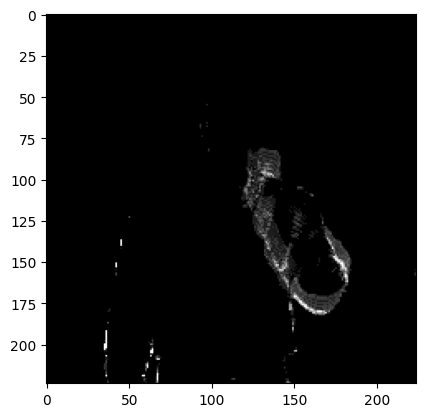

In [51]:
plt.imshow(train_ds[3][0][5], cmap='gray')

In [27]:
!mkdir plots
!mkdir plots/MHI-debug

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [40]:
import time 

ls = [] 

start_t = time.time()
for x,_,y in tqdm(ds):
    ls.append(y)

print(f"iteration through dataset took :  {round(time.time() - start_t, CONFIG.ROUND_DIGIT)} s")

100%|██████████| 100/100 [00:28<00:00,  3.48it/s]

iteration through dataset took :  28.752 s


## Training - Setup

In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LeakyReLU
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import backend as K
from wandb.keras import WandbMetricsLogger
from keras.callbacks import Callback
import tensorflow as tf
import wandb


class CosineAnnealingLearningRateScheduler(Callback):
    def __init__(self, max_lr, min_lr, T_max):
        super(CosineAnnealingLearningRateScheduler, self).__init__()
        self.max_lr = max_lr  # Maximum learning rate (i.e., start learning rate)
        self.min_lr = min_lr  # Minimum learning rate
        self.T_max = T_max    # Specifies the number of epochs per cycle
        self.t = 0            # Current epoch

    def on_epoch_begin(self, epoch, logs=None):
        self.t += 1
        cos = np.cos(np.pi * (self.t % self.T_max) / self.T_max)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + cos)

        keras.backend.set_value(self.model.optimizer.lr, lr)

def keras_train(model, filepath : str, max_lr = 1e-4, min_lr = 5e-5, T_max=50, epochs=100): 
    
    
    checkpoint = keras.callbacks.ModelCheckpoint(filepath,
                                                 monitor="val_categorical_accuracy",
                                                 verbose=0,
                                                 save_best_only=True,
                                                 mode="max",
                                                 save_freq="epoch")
    
    cosine_annealer = CosineAnnealingLearningRateScheduler(max_lr=max_lr,
                                                           min_lr=min_lr,
                                                           T_max=T_max)
    
    #Adam Optimizer - fixed learning rate.
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=max_lr, clipnorm=1.)
    #lr_metric = get_lr_metric(adam_optimizer)

    model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    
    """wandb.init(project=CONFIG.WANDB_RUN,
                     name=run_name,
                     notes="Model summary : \n" + str(model),
                     config={"max_lr" : max_lr, 
                             "min_lr" : 5e-5, 
                             "scheduler" : "cosineAnnealer", 
                             "epochs" : epochs, 
                             "T_max" : T_max, 
                             "train_size" : len(train_dataset_parquet.dataset),
                             "val_size" : len(val_dataset_parquet.dataset),
                             "unique_classes" : len(train_dataset_parquet.unique_labels), 
                             "video_length" : CONFIG.VIDEO_LENGTH,
                             "features" : mediapipe_features
                             }) """
    
    #history = model.fit(train_dataset_parquet, epochs=epochs, validation_data = val_dataset_parquet, batch_size = 8, callbacks=[WandbMetricsLogger(), checkpoint, cosine_annealer])
    history = model.fit(train_ds, epochs=epochs, validation_data = val_ds, batch_size = 8, callbacks=[checkpoint])
    #wandb.finish()
    
    return history

## Train MobileNetV3Small Transfer Learning with ImageNet

In [73]:
MHI_SHAPE = (224,224,3)
#reshaped_data = data.reshape(-1, 480, 640, 1)
# get the base model, exclude final dense layers - we will modify/output this
base_model = tf.keras.applications.MobileNetV3Small(input_shape = MHI_SHAPE,
                                               include_top = False,
                                               weights = 'imagenet',
                                               pooling='max')
# Freeze the convolutional base
base_model.trainable = False
#get the base model summary
#base_model.summary()

In [ ]:
#len(train_ds.unique_labels) outputs the length of the labels.
#MobileNetV3 without additional dense layer - add softmax classification layer
model = Sequential()
model.add(base_model)
model.add(Dense(len(train_ds.unique_labels), activation='softmax'))

keras_train(model, filepath=os.path.join("models", "MHI_MobileNetV3Small.keras"))

Epoch 1/100
10/10 [==============================] - 37s 3s/step - loss: 2.4515 - categorical_accuracy: 0.1875 - val_loss: 2.0709 - val_categorical_accuracy: 0.1500
Epoch 2/100
10/10 [==============================] - 30s 3s/step - loss: 2.3477 - categorical_accuracy: 0.1250 - val_loss: 2.1286 - val_categorical_accuracy: 0.2000
Epoch 3/100
10/10 [==============================] - 29s 3s/step - loss: 2.2401 - categorical_accuracy: 0.1750 - val_loss: 2.1135 - val_categorical_accuracy: 0.1500
Epoch 4/100
10/10 [==============================] - 29s 3s/step - loss: 2.1313 - categorical_accuracy: 0.1500 - val_loss: 1.9778 - val_categorical_accuracy: 0.1500
Epoch 5/100
10/10 [==============================] - 29s 3s/step - loss: 1.9780 - categorical_accuracy: 0.2500 - val_loss: 1.8768 - val_categorical_accuracy: 0.2000
Epoch 6/100
 8/10 [=======================>......] - ETA: 4s - loss: 1.9491 - categorical_accuracy: 0.2344